<a href="https://colab.research.google.com/github/rjaa2020/ML-Theory-and-Applications/blob/main/ENGR208_RNN_only_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedleyVox Artist Recognition
This project aims to identify how many singers are singing during an audio recording.

We will use duet recordings from the MedleyVox dataset, available [here](https://huggingface.co/Cyru5/MedleyVox)

<!-- This project will be largely based on the model building pipeline of HW8 on Language Classification with Transformers. Key deviations are as follows:

1. **Model Selection:** We will be using *speechbrain.pretrained.EncoderClassifier* as our main model
2. **Dataset Building:** We are using MedleyVox duets, since they are split into separate recordings of each vocalist. We will randomly choose 10 vocalists, then split each recording of them into 5 second clips. We will one-hot encode the ground-truth speaker to feed into our model. Use 80-10-10 train-test-validation split to ensure testing is on new data.
2. **Feature Extraction:** Use *Librosa* and *SpeechBrain* to extract relevant features from audio clips. We are considering *spectrograms, MFCCs (Mel-frequency cepstral coefficients), and chromagrams*.
3. **Finetuning:** Our main task will be using and finetuning *speechbrain.pretrained.EncoderClassifier* to classify the 10 speakers in our dataset.
4. **Final Layer:** Add a final linear layer with ReLU activation of size (, 10) to classify the speaker in segment. (ReLU ensures that during testing we can classify more than 1 category).

Testing:
1. We will test on 5 second clips from the duet database -->

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import zipfile
import os

np.random.seed(0)

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 14.3 MB/s eta 0:00:00


In [ ]:
import os
import random
from pydub import AudioSegment
import datetime

# Base directory where the 'AudioFiles/duet' folder is located
base_dir = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox'
duet_dir = os.path.join(base_dir, "duet")

duet_folders = [os.path.join(duet_dir, d) for d in os.listdir(duet_dir) if os.path.isdir(os.path.join(duet_dir, d))]


In [ ]:
def count_files(directory):
  """
  Counts the number of files in a given directory
  """

  file_count = 0
  for root, dirs, files in os.walk(directory):
    file_count += len(files)
  return file_count

print("Total number of files:", count_files(duet_dir))

Total number of files: 351


## RNN method

## Helper Functions

In [ ]:
import os
import shutil

def clear_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
def select_random_audio_file(segment_path):
    """ Selects a random audio file from the given segment path """
    audio_files = [f for f in os.listdir(segment_path) if f.endswith('.wav')]
    return random.sample(audio_files, 1)[0]


def rnn_concatenate_singers(path_list, max_length=5000, num_chunks=20):
    """ Concatenates audio files and creates a singer switch list. """
    combined_audio = None
    singer_switch = []

    for path in path_list:
        audio = AudioSegment.from_file(path)
        audio_len = len(audio)

        if audio_len > max_length:  # Trimming audio if longer than max_length
            rand_len = np.random.randint(2000, 5000)
            audio = audio[:rand_len]

        if combined_audio is None:
            combined_audio = audio
            singer_switch = [1] + [0] * (len(audio) - 1)
        else:
            combined_audio += audio
            singer_switch.extend([1] + [0] * (len(audio) - 1))

        # Ensure the length of singer_switch aligns with combined_audio
        if len(singer_switch) > len(combined_audio):
            singer_switch = singer_switch[:len(combined_audio)]

    rem = len(singer_switch) % num_chunks

    if rem != 0:
      combined_audio = combined_audio[:-rem]
      singer_switch = singer_switch[:-rem]

    return combined_audio, singer_switch

In [ ]:
import torchaudio
import numpy as np
from sklearn.preprocessing import StandardScaler
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

def get_embeddings(PATH, num_chunks=20):
    """
    Splits the given song into num_chunks chunks and calculates the normalized embeddings using Speechbrain's Encoder Classifier
    """

    signal, fs = torchaudio.load(PATH)

    # Calculate chunk size in samples based on the number of chunks
    chunk_size_samples = signal.shape[1] // num_chunks

    # Initialize a list to hold the chunks
    chunks = []

    # Iterate over the signal and extract chunks
    for i in range(num_chunks):
        start = i * chunk_size_samples
        end = signal.shape[1] if i == num_chunks - 1 else start + chunk_size_samples
        chunk = signal[:, start:end]
        chunks.append(chunk)

    embeddings_list = []

    for chunk in chunks:
        # Get the embeddings for each chunk
        embedding = classifier.encode_batch(chunk)

        embedding_np = embedding.numpy() if not isinstance(embedding, np.ndarray) else embedding

        # Append to the list
        embeddings_list.append(embedding_np)

    # Stack all embeddings
    final_embeddings = np.stack(embeddings_list, axis=0)

    N, H, W, D = final_embeddings.shape
    reshaped_embeddings = final_embeddings.reshape(N, H*W*D)

    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(reshaped_embeddings)

    return normalized_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
import numpy as np

np.random.seed(3)

def split_singer_switch(singer_switch, num_chunks=20):
    return np.sum(singer_switch.reshape(num_chunks, -1), axis=1)

# Example usage
singer_switch = np.random.choice([0, 1], size=10000, replace=True, p=[0.9998, 0.0002])  # Replace with your actual data
split_singer_switch(singer_switch)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def hamming_loss(y_true, y_pred):
    """
    Computes the Hamming loss, which is the fraction of labels that are incorrectly predicted.
    """
    # Convert input to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Check for same shape
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape of predicted and true values do not match.")

    # Count the number of label mismatches
    n_labels = y_true.shape[1]
    n_samples = y_true.shape[0]
    incorrect_labels = np.sum(y_true != y_pred)

    # Calculate the hamming loss
    return incorrect_labels / (n_samples * n_labels)

# Example usage
y_true = [[1, 0, 1], [0, 1, 0], [1, 1, 1]]
y_pred = [[0, 0, 1], [1, 1, 0], [1, 0, 1]]

loss = hamming_loss(y_true, y_pred)
print(f"Hamming Loss: {loss}")

Hamming Loss: 0.3333333333333333


Define a "TrainingSong" data type. The class stores:
1.   The number of chunks the song is split into
2.   The file path
3.   The file name
4.   The number of singers
5.   An array of len(audio), where 1 = switch, and 0 != switch
6.   The indices of switch
7.   The *num_chunks* embeddings
8.   A *num_chunks* binary array indicating if a switch occurred or not



In [ ]:
class TrainingSong:
    def __init__(self, filepath, num_singers, singer_switch, num_chunks=20):
        self.num_chunks = num_chunks
        self.file_path = filepath
        self.file_name = self.file_path.split('/')[-1]
        self.num_singers = num_singers
        self.singer_switch = np.array(singer_switch)

        assert len(self.singer_switch) % self.num_chunks == 0, f"{len(self.singer_switch)=} is not divisible by {self.num_chunks=}"

        self.indices_of_switch = [i for i, x in enumerate(self.singer_switch) if x == 1]
        self.ground_truth = self.indices_of_switch + ([None]*(8 - len(self.indices_of_switch)))
        self.embeddings = get_embeddings(self.file_path, self.num_chunks)
        self.switches = split_singer_switch(self.singer_switch, self.num_chunks)


    def __repr__(self):
      return self.file_name.split('.')[0]

    def __str__(self):
        return f"{self.file_name} has {self.num_singers:02} singers with switches at {self.indices_of_switch} and {self.num_chunks} chunks"

In [ ]:
import datetime
import pickle

# Base directory where the 'AudioFiles/duet' folder is located
base_dir = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox'
duet_dir = os.path.join(base_dir, "duet")

output_dir = os.path.join(base_dir, "RNN_ConcatenatedAudios2") # Directory to save the new audio file
duet_folders = [os.path.join(duet_dir, d) for d in os.listdir(duet_dir) if os.path.isdir(os.path.join(duet_dir, d))]
pickle_file_path = os.path.join(output_dir, 'training_songs.pkl')
num_chunks = 10

generate_new_data = False

if generate_new_data:

  clear_directory(output_dir)

  num_iterations = 200  # create num_iterations concatenated files
  training_data = []

  for i in range(num_iterations):
      # Randomly decide how many singers to include (between 2 and 7)
      num_singers = np.random.randint(2, 8)
      # num_singers = 2

      # Randomly select 'num_singers' different duet folders
      selected_duets = random.sample(duet_folders, num_singers)

      # Select a random segment from each duet folder and pick one audio file from each
      audio_files = []
      for duet_folder in selected_duets:
          segments = [os.path.join(duet_folder, d) for d in os.listdir(duet_folder) if os.path.isdir(os.path.join(duet_folder, d))]
          selected_segment = np.random.choice(segments, replace=False)
          gt_path = os.path.join(selected_segment, "gt")
          selected_audio = select_random_audio_file(gt_path)
          audio_files.append(os.path.join(gt_path, selected_audio))

      # Generate a unique timestamp
      timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")

      # Concatenate the selected audio files
      result_audio, singer_switch = rnn_concatenate_singers(audio_files, 5000)

      # Define a unique file name for each output
      output_file_name = f"combined_output_{num_singers}_singers_{timestamp}.wav"
      output_file_path = os.path.join(output_dir, output_file_name)

      # Export the result into the new folder
      result_audio.export(output_file_path, format="wav")

      new_song = TrainingSong(output_file_path, num_singers, singer_switch, num_chunks)
      print(f"{i:03}. {new_song}")
      training_data.append(new_song)

  # Save
  with open(pickle_file_path, 'wb') as f:
    pickle.dump(np.array(training_data), f)
    print()

else:
  # Load
  with open(pickle_file_path, 'rb') as f:
      training_data = pickle.load(f)

  print("loaded training_songs:")
  for i, song in enumerate(training_data):
    print(f"  {i:03}. {song}")

loaded training_songs:
  000. combined_output_4_singers_20231209072028703087.wav has 04 singers with switches at [0, 3526, 7928, 11422] and 10 chunks
  001. combined_output_4_singers_20231209072029283782.wav has 04 singers with switches at [0, 4154, 8734, 12609] and 10 chunks
  002. combined_output_6_singers_20231209072030025047.wav has 06 singers with switches at [0, 3875, 6167, 11091, 15048, 18932] and 10 chunks
  003. combined_output_5_singers_20231209072030932043.wav has 05 singers with switches at [0, 4226, 6914, 11191, 15351] and 10 chunks
  004. combined_output_6_singers_20231209072031699817.wav has 06 singers with switches at [0, 4016, 8787, 13686, 17269, 22194] and 10 chunks
  005. combined_output_3_singers_20231209072032663755.wav has 03 singers with switches at [0, 3493, 7339] and 10 chunks
  006. combined_output_5_singers_20231209072033166257.wav has 05 singers with switches at [0, 3112, 6608, 11395, 15480] and 10 chunks
  007. combined_output_2_singers_20231209072034031946

In [ ]:
for i, song in enumerate(training_data[:20]):
   print(f"song {i:03}. embeddings shape: {song.embeddings.shape}\tswitches: {song.switches}")

song 000. embeddings shape: (10, 512)	switches: [1 0 1 0 0 1 0 0 1 0]
song 001. embeddings shape: (10, 512)	switches: [1 0 1 0 0 1 0 1 0 0]
song 002. embeddings shape: (10, 512)	switches: [1 1 1 0 1 0 1 0 1 0]
song 003. embeddings shape: (10, 512)	switches: [1 0 1 1 0 0 1 0 1 0]
song 004. embeddings shape: (10, 512)	switches: [1 1 0 1 0 1 1 0 1 0]
song 005. embeddings shape: (10, 512)	switches: [1 0 0 1 0 0 1 0 0 0]
song 006. embeddings shape: (10, 512)	switches: [1 1 0 1 0 0 1 0 1 0]
song 007. embeddings shape: (10, 512)	switches: [1 0 0 0 0 0 1 0 0 0]
song 008. embeddings shape: (10, 512)	switches: [1 0 1 0 0 1 1 0 0 0]
song 009. embeddings shape: (10, 512)	switches: [1 0 0 0 0 1 0 1 0 0]
song 010. embeddings shape: (10, 512)	switches: [1 0 1 0 1 0 0 1 0 0]
song 011. embeddings shape: (10, 512)	switches: [1 0 0 1 0 0 0 0 0 0]
song 012. embeddings shape: (10, 512)	switches: [1 1 0 1 1 0 1 1 1 0]
song 013. embeddings shape: (10, 512)	switches: [1 0 0 1 0 1 0 0 0 0]
song 014. embeddings

Epoch [1/20], Loss: 0.6812
Epoch [2/20], Loss: 0.6361
Epoch [3/20], Loss: 0.5658
Epoch [4/20], Loss: 0.5309
Epoch [5/20], Loss: 0.5009
Epoch [6/20], Loss: 0.4606
Epoch [7/20], Loss: 0.4127
Epoch [8/20], Loss: 0.3508
Epoch [9/20], Loss: 0.2901
Epoch [10/20], Loss: 0.2263
Epoch [11/20], Loss: 0.1729
Epoch [12/20], Loss: 0.1286
Epoch [13/20], Loss: 0.0945
Epoch [14/20], Loss: 0.0679
Epoch [15/20], Loss: 0.0467
Epoch [16/20], Loss: 0.0334
Epoch [17/20], Loss: 0.0152
Epoch [18/20], Loss: 0.0058
Epoch [19/20], Loss: -0.0068
Epoch [20/20], Loss: -0.0135


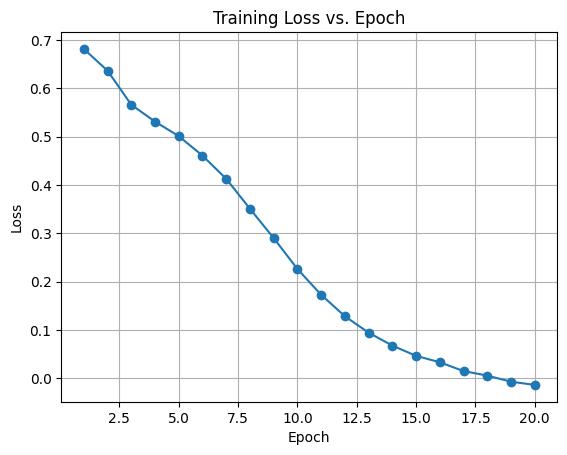

In [ ]:
import torch
import torch.nn as nn
import torchaudio
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Define the dataset class
class AudioDataset(Dataset):
    def __init__(self, data):
        self.embeddings = [song.embeddings for song in data]
        self.labels = [song.switches for song in data]

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):

      return self.embeddings[idx], self.labels[idx]

# # Define the RNN model
# class RNNClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(RNNClassifier, self).__init__()
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out[:, -1, :])
#         return out

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        # Make LSTM bidirectional
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True)
        # Adjust the input size of the linear layer
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        # Concatenate the outputs from both directions
        out = self.fc(out[:, -1, :])
        return out


# Parameters (you'll need to determine appropriate values)
input_size = 512 # Depends on your feature extraction
hidden_size = 128
num_layers = 2
num_classes = num_chunks # Adjust based on your dataset

# Initialize model, loss, and optimizer
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

from sklearn.model_selection import train_test_split

# build train/test datasets and loaders
train_data, test_data = train_test_split(training_data, train_size=0.7, shuffle=True, random_state=2)
train_dataset = AudioDataset(train_data)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataset = AudioDataset(test_data)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=True)

import matplotlib.pyplot as plt

num_epochs = 20

# Initialize a list to store the loss values
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels.float())  # Ensure labels are float type

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plotting the training loss
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()

            # Applying sigmoid to the outputs to get the predictions
            predicted = torch.sigmoid(outputs).data > 0.5
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all the predictions and labels
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    df = pd.DataFrame(all_preds.reshape((-1, 20)))

    # Calculate Hamming Loss
    acc = 1 - hamming_loss(all_labels, all_preds)
    # acc = 0

    avg_loss = total_loss / len(test_loader)
    return avg_loss, acc, all_preds, all_labels

# Evaluate the model
avg_loss, h_loss, all_preds, all_labels = evaluate_model(model, test_loader, criterion)
print(f'Average Loss: {avg_loss:.4f}, Hamming Accuracy: {h_loss:.2%}')

Average Loss: 0.7657, Hamming Accuracy: 64.00%


accuracy (+/- 0) = 51.67%
accuracy (+/- 1) = 73.33%
accuracy (+/- 2) = 91.67%
000. [1 0 0 1 0 0 1 0 0 0]	predicted: 3	actual: 2	diff: -1
001. [1 0 1 0 0 1 0 1 0 0]	predicted: 4	actual: 7	diff: 3
002. [1 0 1 0 0 1 0 1 1 0]	predicted: 5	actual: 3	diff: -2
003. [1 0 0 0 0 0 0 0 0 0]	predicted: 1	actual: 3	diff: 2
004. [1 1 0 1 0 1 1 0 1 0]	predicted: 6	actual: 5	diff: -1
005. [1 0 1 0 0 1 0 0 0 0]	predicted: 3	actual: 2	diff: -1
006. [1 1 0 0 0 0 0 0 0 0]	predicted: 2	actual: 3	diff: 1
007. [1 1 0 0 1 0 1 0 1 0]	predicted: 5	actual: 2	diff: -3
008. [1 1 0 1 0 1 0 1 1 0]	predicted: 6	actual: 7	diff: 1
009. [1 1 0 1 0 1 0 1 0 0]	predicted: 5	actual: 5	diff: 0
010. [1 1 0 0 1 0 1 0 0 0]	predicted: 4	actual: 7	diff: 3
011. [1 0 1 0 0 1 0 0 1 0]	predicted: 4	actual: 4	diff: 0
012. [1 0 1 0 1 0 0 1 0 0]	predicted: 4	actual: 4	diff: 0
013. [1 1 1 1 0 1 0 1 0 0]	predicted: 6	actual: 7	diff: 1
014. [1 0 1 0 0 1 0 0 0 0]	predicted: 3	actual: 2	diff: -1
015. [1 1 0 1 1 1 1 0 1 0]	predicted: 7	actual

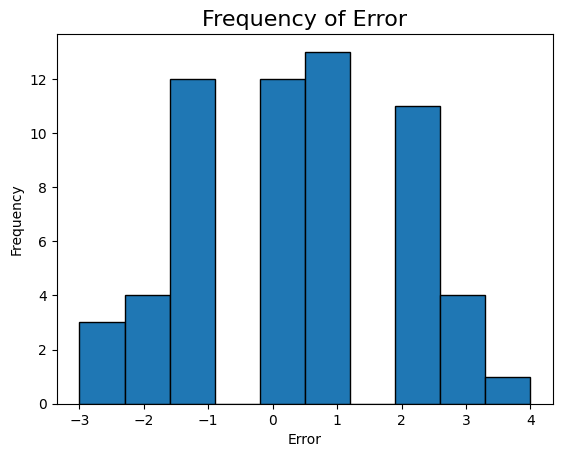

In [ ]:
predicted_singers = np.sum(all_preds, axis=1)
actual_singers = np.sum(all_labels, axis=1)
diff = actual_singers - predicted_singers
accuracy = np.mean(np.abs(diff) <= 2)
print(f"accuracy (+/- 0) = {np.mean(diff <= 0):.2%}")
print(f"accuracy (+/- 1) = {np.mean(diff <= 1):.2%}")
print(f"accuracy (+/- 2) = {np.mean(diff <= 2):.2%}")

import matplotlib.pyplot as plt

plt.hist(diff, ec='black')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Frequency of Error", size=16)

for i in range(all_preds.shape[0]):
  preds = all_preds[i].astype(int)
  pred_singers = predicted_singers[i]
  act_singers = actual_singers[i]
  print(f"{i:03}. {preds}\tpredicted: {pred_singers}\tactual: {act_singers}\tdiff: {diff[i]}")

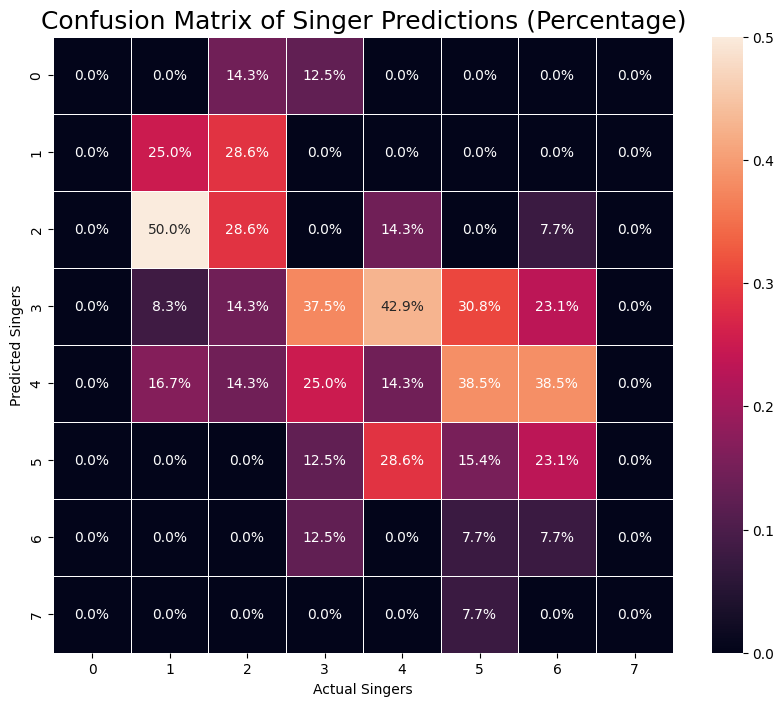

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming predicted_singers and actual_singers are defined
conf_mat = confusion_matrix(predicted_singers, actual_singers)

# Convert to percentage
conf_mat_pct = conf_mat / [max(v, 1) for v in np.sum(conf_mat, axis=0)]

# Set up figure for the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap with percentages
sns.heatmap(conf_mat_pct,
            annot=True,  # Enable annotations
            fmt='.1%',  # Format for the annotations
            linewidths=.5,  # Gridline width
            cbar=True) # Show color bar

# Labeling
plt.xlabel('Actual Singers')
plt.ylabel('Predicted Singers')
plt.title('Confusion Matrix of Singer Predictions (Percentage)', size=18)

# Display the heatmap
plt.show()


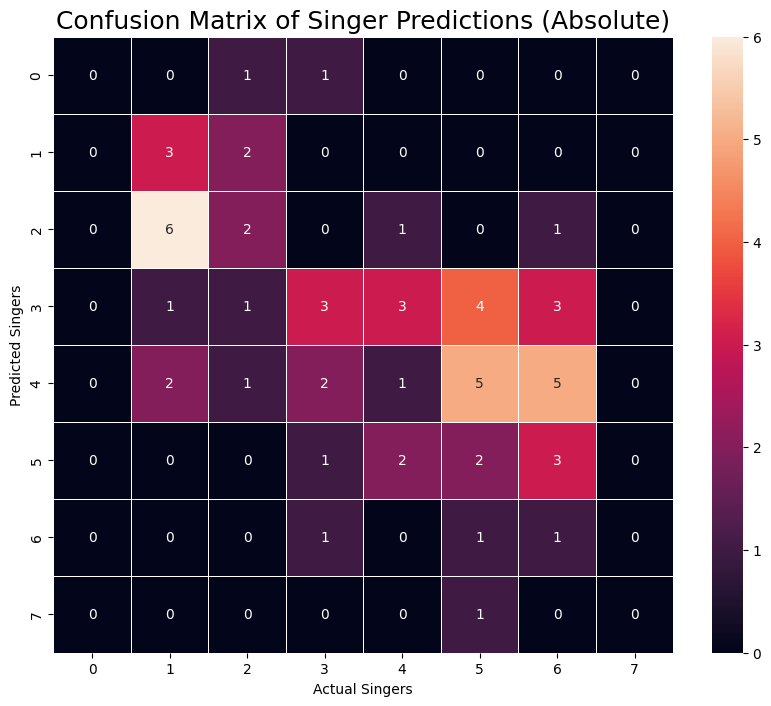

array([ 0, 12,  7,  8,  7, 13, 13,  0])

In [ ]:
# Set up figure for the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap with percentages
sns.heatmap(conf_mat,
            annot=True,  # Enable annotations
            linewidths=.5,  # Gridline width
            cbar=True)  # Show color bar

# Labeling
plt.xlabel('Actual Singers')
plt.ylabel('Predicted Singers')
plt.title('Confusion Matrix of Singer Predictions (Absolute)', size=18)

# Display the heatmap
plt.show()

np.sum(conf_mat, axis=0)